In [245]:
import pandas as pd
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from collections import Counter
from ast import literal_eval
import ast




# Step 1: Merge Data

In [1]:


# Paths to the files are given by the user
calendar_files = {
    '2022_09': '2022_09_calendar.csv',
    '2022_12': '2022_12_calendar.csv',
    '2023_03': '2023_03_calendar.csv',
    '2023_06': '2023_06_calendar.csv',
    '2023_09': '2023_09_calendar.csv',
}

listings_files = {
    '2022_09': '2022_09_listings.csv',
    '2022_12': '2022_12_listings.csv',
    '2023_03': '2023_03_listings.csv',
    '2023_06': '2023_06_listings.csv',
    '2023_09': '2023_09_listings.csv',
}

# Initialize an empty DataFrame to hold the merged data
merged_data = pd.DataFrame()

for period in calendar_files:
    calendar_path = calendar_files[period]
    listings_path = listings_files[period]

    # Read the calendar and listings data
    calendar_df = pd.read_csv(calendar_path)
    listings_df = pd.read_csv(listings_path)

    # Convert 'date' in calendar_df to datetime and ensure IDs are of the same type
    calendar_df['date'] = pd.to_datetime(calendar_df['date']).dt.date
    calendar_df['listing_id'] = calendar_df['listing_id'].astype(str)
    listings_df['id'] = listings_df['id'].astype(str)

    # Create a 'price_listing' column in listings data
    listings_df['price_listing'] = listings_df['price']
    listings_df['minimum_nights_listing'] = listings_df['minimum_nights']
    listings_df['maximum_nights_listing'] = listings_df['maximum_nights']

    # Keep only necessary columns from calendar and listings data
    calendar_df = calendar_df[['listing_id', 'date', 'available', 'price', 'minimum_nights', 'maximum_nights']]
    listings_columns_to_keep = [
        'id',  # Unique identifier for the listing
        'price_listing',  # Assuming this is the target variable: price
        'minimum_nights_listing',  # Minimum nights required to book
        'maximum_nights_listing',  # Maximum nights available to book
        'host_since',  # Date when the host started on Airbnb
        'host_verifications',  # Types of host verification
        'host_acceptance_rate',  # Rate at which the host accepts booking requests
        'host_is_superhost',  # Whether the host has Superhost status
        'neighbourhood_cleansed',  # Normalized location information
        'property_type',  # Type of property being offered
        'room_type',  # Type of room being offered
        'accommodates',  # Number of guests the listing can accommodate
        'bathrooms_text',  # Description of bathrooms available
        'bedrooms',  # Number of bedrooms included in the listing
        'beds',  # Number of beds included in the listing
        'amenities',  # Amenities offered with the listing
        'license',  # The license or registration number
        'number_of_reviews',  # Total number of reviews
        'number_of_reviews_l30d',  # Number of reviews in the last 30 days
        'review_scores_rating',  # Overall rating score given by reviewers
        'availability_30',  # Availability over the next 30 days
        'availability_60',  # Availability over the next 60 days
        'availability_90',  # Availability over the next 90 days
        'availability_365',  # Availability over the next 365 days
        'instant_bookable',  # Indicates if the listing can be booked instantly
        'calculated_host_listings_count',  # Number of listings the host has in total
        'host_response_time',  # Average time the host takes to respond to messages
        'host_response_rate',  # Percentage of messages the host responds to
        'host_listings_count',  # Number of listings a host manages (from my original list)
        'host_identity_verified',  # Whether the host's identity has been verified (from my original list)
        'review_scores_accuracy',  # Accuracy of the listing description as rated by reviewers (from my original list)
        'review_scores_cleanliness',  # Cleanliness score as rated by reviewers (from my original list)
        'review_scores_checkin',  # Check-in experience score as rated by reviewers (from my original list)
        'review_scores_communication',  # Communication score as rated by reviewers (from my original list)
        'review_scores_location',  # Location score as rated by reviewers (from my original list)
        'review_scores_value',  # Value score as rated by reviewers (from my original list)
        'reviews_per_month'  # Average number of reviews per month (from my original list)
    ]

    listings_df = listings_df[listings_columns_to_keep]

    # Find missing IDs and their date range
    missing_ids = set(listings_df['id']) - set(calendar_df['listing_id'])
    date_range = pd.date_range(start=calendar_df['date'].min(), end=calendar_df['date'].max())

    # For each missing ID, create new rows
    for missing_id in missing_ids:
        listing_details = listings_df[listings_df['id'] == missing_id]
        missing_rows = pd.DataFrame({
            'listing_id': missing_id,
            'date': date_range,
            'available': 'f',
            'price': listing_details['price_listing'].values[0],
            'minimum_nights': listing_details['minimum_nights_listing'].values[0],
            'maximum_nights': listing_details['maximum_nights_listing'].values[0]
        })
        calendar_df = pd.concat([calendar_df, missing_rows], ignore_index=True)

 # Merge calendar data with the corresponding listings data
    period_merged_data = calendar_df.merge(listings_df, how='left', left_on='listing_id', right_on='id')

 # Append the period data to the full merged dataset
    merged_data = pd.concat([merged_data, period_merged_data], ignore_index=True)

# Drop duplicates, if any
merged_data.drop_duplicates(subset=['listing_id', 'date'], keep='last', inplace=True)

# Handle missing values
merged_data.fillna(method='ffill', inplace=True)

# Save the cleaned, merged data to a new CSV file
output_file = 'merged_cleaned_data.csv'
merged_data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Processed data saved to merged_cleaned_data.csv


# Step 2: Data Cleaning Procedures

In [306]:
# Load the dataset
file_path = 'merged_cleaned_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Convert 't' and 'f' to 1 and 0
for col in data.columns:
    unique_values = data[col].dropna().unique()
    if set(unique_values) == {'t', 'f'}:
        data[col] = data[col].map({'t': 1, 'f': 0})

# Convert 'bathrooms_text' to numerical
data['bathrooms'] = data['bathrooms_text'].str.extract('(\d+)').astype(float)

# Count the number of amenities and add as a new column
data['amenities_count'] = data['amenities'].str.count(',') + 1

# Drop the original 'bathrooms_text' and 'amenities' columns
data.drop(columns=['bathrooms_text', 'amenities'], inplace=True)

# Convert specific columns to binary (0 or 1)
data['license'] = data['license'].notna().astype(int)

# Define the date range
data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is in datetime format
start_date = data['date'].min()  # Get the earliest date from your data
end_date = pd.to_datetime('2023-12-31')  # End of the date range you want to plot

# Add the week/weekend variable based on 'date'
data['weekend'] = (data['date'].dt.dayofweek >= 5).astype(int)  # Encode Saturday and Sunday as 1, other days as 0

# Calculate the week indicator from the start date
data['week_indicator'] = (data['date'] - start_date).dt.days // 7  # Integer division by 7 for weeks

# Convert 'host_since' to datetime and calculate months to December 31, 2023
end_date = pd.to_datetime('2023-12-31')
data['host_since_mos'] = (end_date.year - pd.to_datetime(data['host_since']).dt.year) * 12 + end_date.month - pd.to_datetime(data['host_since']).dt.month

# Convert 'date' column back to a string in the original format
# Assuming the original format was 'YYYY-MM-DD'
data['date'] = data['date'].dt.strftime('%Y-%m-%d')

# Convert 't' and 'f' to 1 and 0, including 'TRUE' and 'FALSE'
for col in data.columns:
    unique_values = data[col].dropna().unique()
    if set(unique_values) == {'t', 'f'} or set(unique_values) == {True, False}:
        data[col] = data[col].map({'t': 1, 'f': 0, True: 1, False: 0})

# Functions to detect datetime and numeric columns
def is_datetime(col):
    try:
        pd.to_datetime(data[col], errors='raise')
        return True
    except ValueError:
        return False

def is_numeric(col):
    temp_col = data[col].replace('[%\$€£₹¥,;:]', '', regex=True)
    temp_col = pd.to_numeric(temp_col, errors='coerce')
    return pd.notnull(temp_col).any()

# Function to check if a column is binary
def is_binary(col):
    return sorted(data[col].dropna().unique()) == [0, 1]

# Classify columns
numerical_cols = []
categorical_cols = []
dummy_cols = [] 
date_cols = []

for col in data.columns:
    if data[col].dtype == 'object':
        if is_datetime(col):
            date_cols.append(col)
            data[col] = pd.to_datetime(data[col], errors='coerce')
        elif is_numeric(col):
            data[col] = data[col].replace('[%\$€£₹¥,;:]', '', regex=True)
            numerical_cols.append(col)
            data[col] = pd.to_numeric(data[col], errors='coerce')
        else:
            categorical_cols.append(col)
    elif data[col].dtype in ['int64', 'float64']:
        if is_binary(col):
            dummy_cols.append(col)
        else:
            numerical_cols.append(col)
    elif data[col].dtype == 'bool':
        dummy_cols.append(col)
    else:
        # Handle other data types as needed
        # For now, categorizing as 'categorical_cols'
        categorical_cols.append(col)

# # Replace spaces with underscores in categorical column names
# for col in categorical_cols:
#     data.rename(columns={col: col.replace(' ', '_')}, inplace=True)
# # Apply One-hot encode categorical columns+
# data = pd.get_dummies(data, columns=categorical_cols)

# Apply Binary Encoding to categorical columns
# encoder = ce.BinaryEncoder(cols=categorical_cols)
# data_encoded = encoder.fit_transform(data[categorical_cols])

# # Concatenate the encoded columns with the original data, excluding original categorical columns
# data = pd.concat([data.drop(categorical_cols, axis=1), data_encoded], axis=1)

# Output the updated DataFrame structure
print(data.info())

# Output the column types
print("Numerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)
print("Dummy columns:", dummy_cols)
print("Date columns:", date_cols)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3864359 entries, 0 to 3864358
Data columns (total 46 columns):
 #   Column                          Dtype         
---  ------                          -----         
 0   listing_id                      int64         
 1   date                            datetime64[ns]
 2   available                       int64         
 3   price                           float64       
 4   minimum_nights                  float64       
 5   maximum_nights                  float64       
 6   id                              int64         
 7   price_listing                   float64       
 8   minimum_nights_listing          int64         
 9   maximum_nights_listing          int64         
 10  host_since                      datetime64[ns]
 11  host_verifications              object        
 12  host_acceptance_rate            int64         
 13  host_is_superhost               int64         
 14  neighbourhood_cleansed          object        
 15

In [307]:
# Display rows where 'bathrooms' is missing
missing_bathrooms_data = data[data['bathrooms'].isna()]
print(missing_bathrooms_data.head())  # Display the first few rows

# Statistical summary of the 'bathrooms' column
print("\nStatistical Summary of 'bathrooms':")
print(data['bathrooms'].describe())

       listing_id       date  available  price  minimum_nights  \
21839    13082258 2022-09-15          0   52.0            91.0   
21840    13082258 2022-09-16          0   52.0            91.0   
21841    13082258 2022-09-17          0   52.0            91.0   
21842    13082258 2022-09-18          0   52.0            91.0   
21843    13082258 2022-09-19          0   52.0            91.0   

       maximum_nights        id  price_listing  minimum_nights_listing  \
21839          1125.0  13082258           52.0                      91   
21840          1125.0  13082258           52.0                      91   
21841          1125.0  13082258           52.0                      91   
21842          1125.0  13082258           52.0                      91   
21843          1125.0  13082258           52.0                      91   

       maximum_nights_listing  ... review_scores_checkin  \
21839                    1125  ...                   5.0   
21840                    1125  ...    

In [308]:
# Fill missing values in 'bathrooms' with 0
data['bathrooms'].fillna(0, inplace=True)

# Optionally, check if there are any remaining missing values in 'bathrooms'
missing_bathrooms = data['bathrooms'].isna().sum()
print("Missing values in bathrooms after filling:", missing_bathrooms)



Missing values in bathrooms after filling: 0


In [309]:
# Save the cleaned data
cleaned_data_path = 'final_boston_data.csv'
data.to_csv(cleaned_data_path, index=False)

In [310]:
# Generate a summary table with two decimal points
summary_table = data.describe(include='all').applymap(lambda x: round(x, 2) if isinstance(x, float) else x)

print(summary_table)

C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\867474558.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  summary_table = data.describe(include='all').applymap(lambda x: round(x, 2) if isinstance(x, float) else x)


          listing_id                 date   available       price  \
count   3.864359e+06              3864359  3864359.00  3864359.00   
unique           NaN                  731         NaN         NaN   
top              NaN  2023-08-29 00:00:00         NaN         NaN   
freq             NaN                 6698         NaN         NaN   
first            NaN  2022-09-15 00:00:00         NaN         NaN   
last             NaN  2024-09-14 00:00:00         NaN         NaN   
mean    2.614182e+17                  NaN        0.52      237.77   
std     3.576345e+17                  NaN        0.50      349.53   
min     3.168000e+03                  NaN        0.00        0.00   
25%     2.541631e+07                  NaN        0.00       98.00   
50%     4.860119e+07                  NaN        1.00      174.00   
75%     6.522855e+17                  NaN        1.00      278.00   
max     9.804836e+17                  NaN        1.00    15300.00   

        minimum_nights  maximum_n

C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\227100694.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 1], x='date', y='price', label='Treatment', ci=None)
C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\227100694.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 0], x='date', y='price', label='Control', ci=None)


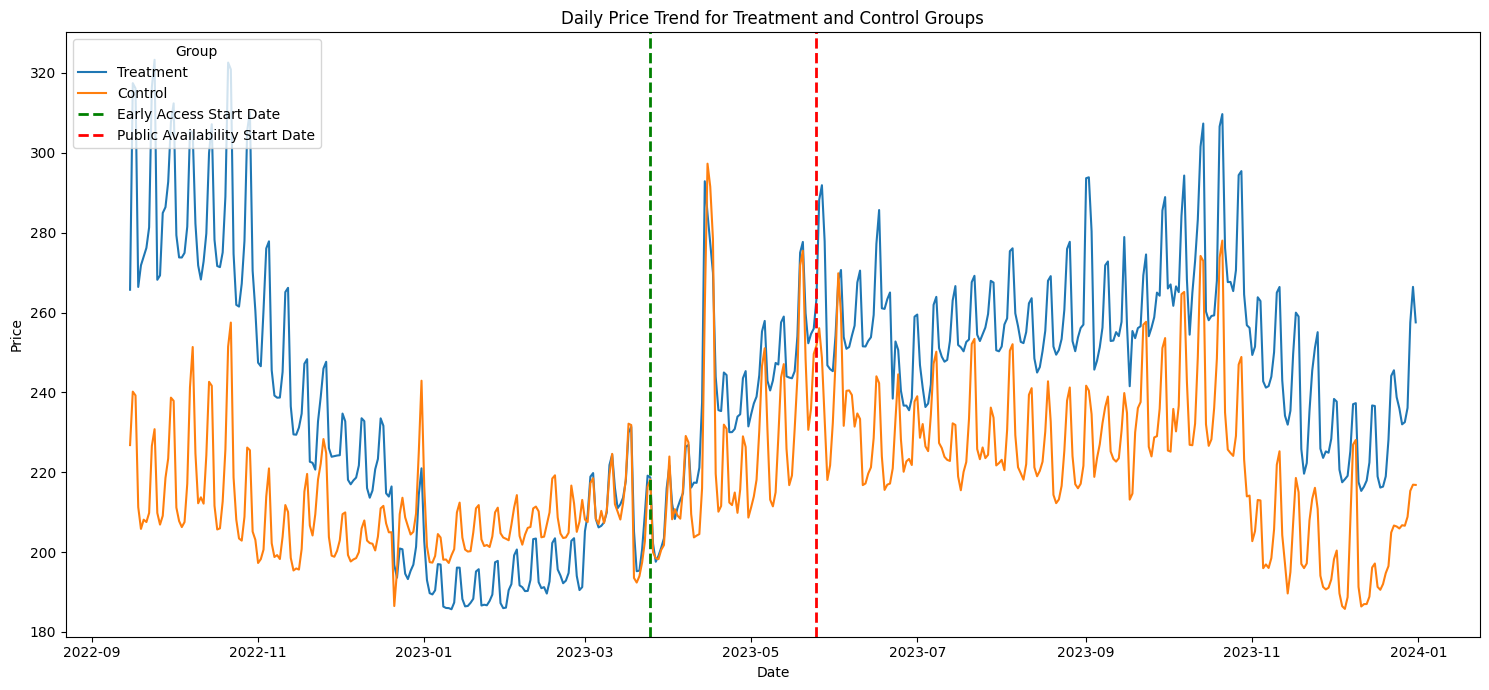

In [311]:
# Define the date range
data['date'] = pd.to_datetime(data['date'])  # Ensure 'date' is in datetime format
start_date = data['date'].min()  # Get the earliest date from your data
end_date = pd.to_datetime('2023-12-31')  # End of the date range you want to plot

# Filter data for the date range
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Define cutoff dates for the introduction of the Smart Pricing tool
early_access_start = pd.to_datetime('2023-03-25')
public_availability_start = pd.to_datetime('2023-05-25')

# Plotting
plt.figure(figsize=(15, 7))

# Treatment group plot
sns.lineplot(data=data[data['available'] == 1], x='date', y='price', label='Treatment', ci=None)

# Control group plot
sns.lineplot(data=data[data['available'] == 0], x='date', y='price', label='Control', ci=None)

# Highlight the policy change dates
plt.axvline(x=pd.to_datetime('2023-03-25'), color='green', linestyle='--', lw=2, label='Early Access Start Date')
plt.axvline(x=pd.to_datetime('2023-05-25'), color='red', linestyle='--', lw=2, label='Public Availability Start Date')

# Improve the legend
plt.legend(title='Group', loc='upper left')

# Title and labels
plt.title('Daily Price Trend for Treatment and Control Groups')
plt.xlabel('Date')
plt.ylabel('Price')

# Tight layout for saving
plt.tight_layout()

# Show plot
plt.show()

C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\2056561316.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 1], x='date', y='price_smoothed', label='Treatment', ci=None)
C:\Users\yirsu\AppData\Local\Temp\ipykernel_18688\2056561316.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available'] == 0], x='date', y='price_smoothed', label='Control', ci=None)


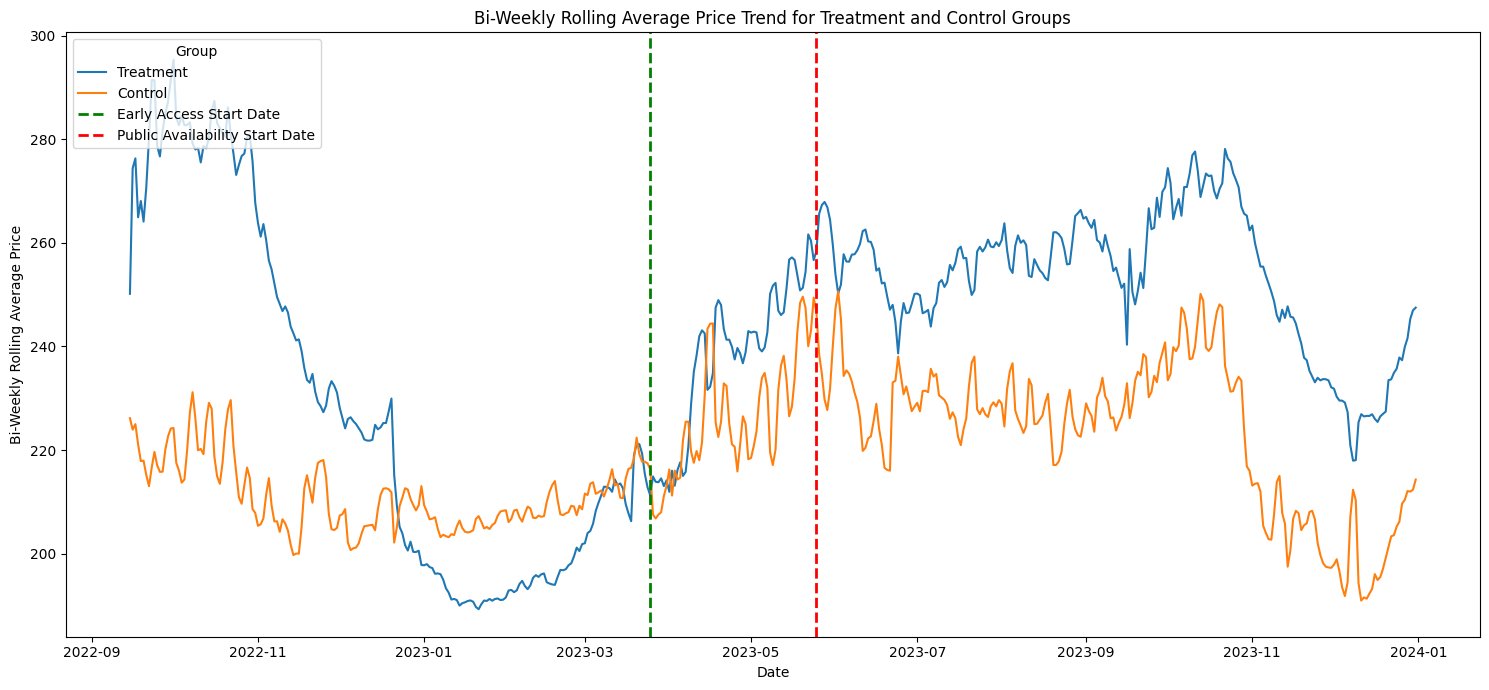

In [312]:
data['price_smoothed'] = data.groupby('available')['price'].transform(lambda x: x.rolling(14, center=True).mean())

# Plotting
plt.figure(figsize=(15, 7))

# Treatment group plot
sns.lineplot(data=data[data['available'] == 1], x='date', y='price_smoothed', label='Treatment', ci=None)

# Control group plot
sns.lineplot(data=data[data['available'] == 0], x='date', y='price_smoothed', label='Control', ci=None)

# Highlight the policy change dates
plt.axvline(x=pd.to_datetime('2023-03-25'), color='green', linestyle='--', lw=2, label='Early Access Start Date')
plt.axvline(x=pd.to_datetime('2023-05-25'), color='red', linestyle='--', lw=2, label='Public Availability Start Date')

# Improve the legend
plt.legend(title='Group', loc='upper left')

# Title and labels
plt.title('Bi-Weekly Rolling Average Price Trend for Treatment and Control Groups')
plt.xlabel('Date')
plt.ylabel('Bi-Weekly Rolling Average Price')

# Tight layout for saving
plt.tight_layout()

# Show plot
plt.show()


### IVs should have the following characteristics:

* Strongly correlated with available_dummy (the treatment variable).
* Not correlated or very weakly correlated with the price (the outcome variable), which is not shown in this correlation matrix but is necessary to check.

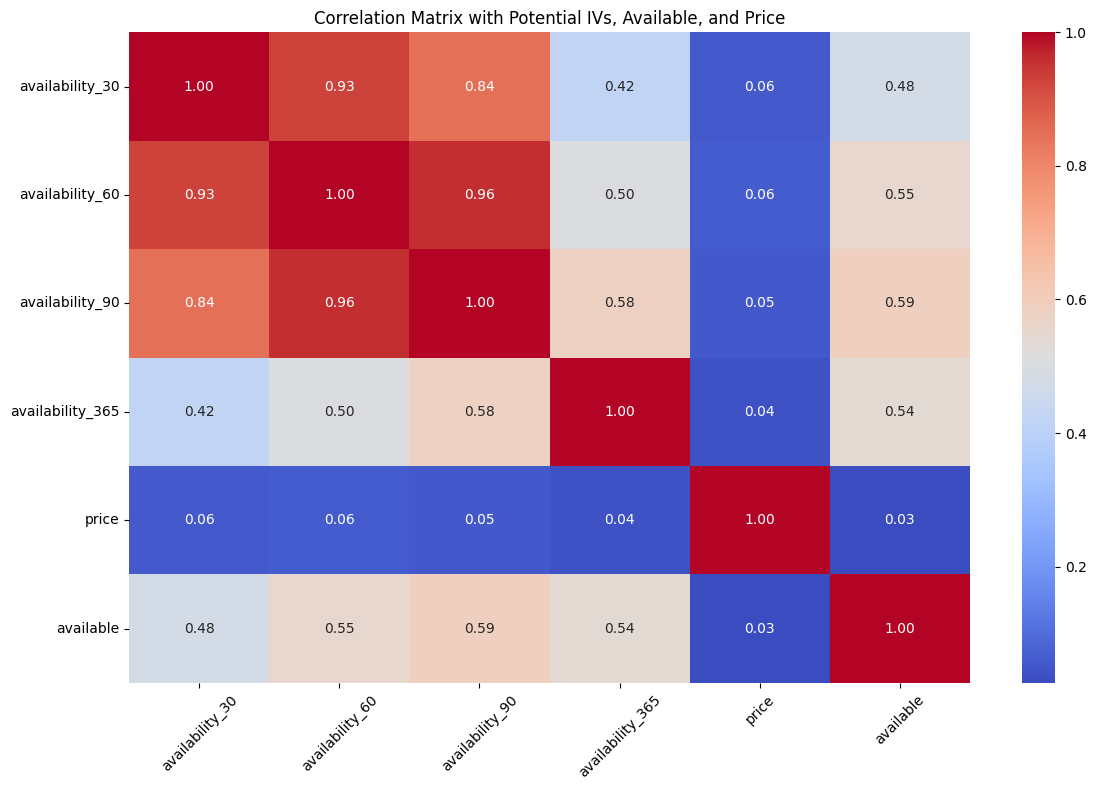

['availability_30', 'availability_60', 'availability_90', 'availability_365']


In [313]:
# Exclude non-relevant variables from the correlation matrix
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 'minimum_nights_listing', 
                 'maximum_nights_listing']
all_cols = data.columns.tolist()
relevant_cols = [col for col in all_cols if col not in excluded_vars]

# Calculate the correlation matrix
corr_matrix = data[relevant_cols].corr()

# Define thresholds and identify potential IVs
corr_with_treatment_threshold = 0.2 # Min
corr_with_price_threshold = 0.1 # Max
potential_ivs = [col for col in corr_matrix.columns if (col != 'available') and (abs(corr_matrix.loc[col, 'available']) > corr_with_treatment_threshold) and (abs(corr_matrix.loc[col, 'price']) < corr_with_price_threshold)]

# Plot the final correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.loc[potential_ivs + ['price', 'available'], potential_ivs + ['price', 'available']], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix with Potential IVs, Available, and Price")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
print(potential_ivs)

In [314]:
ivs = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

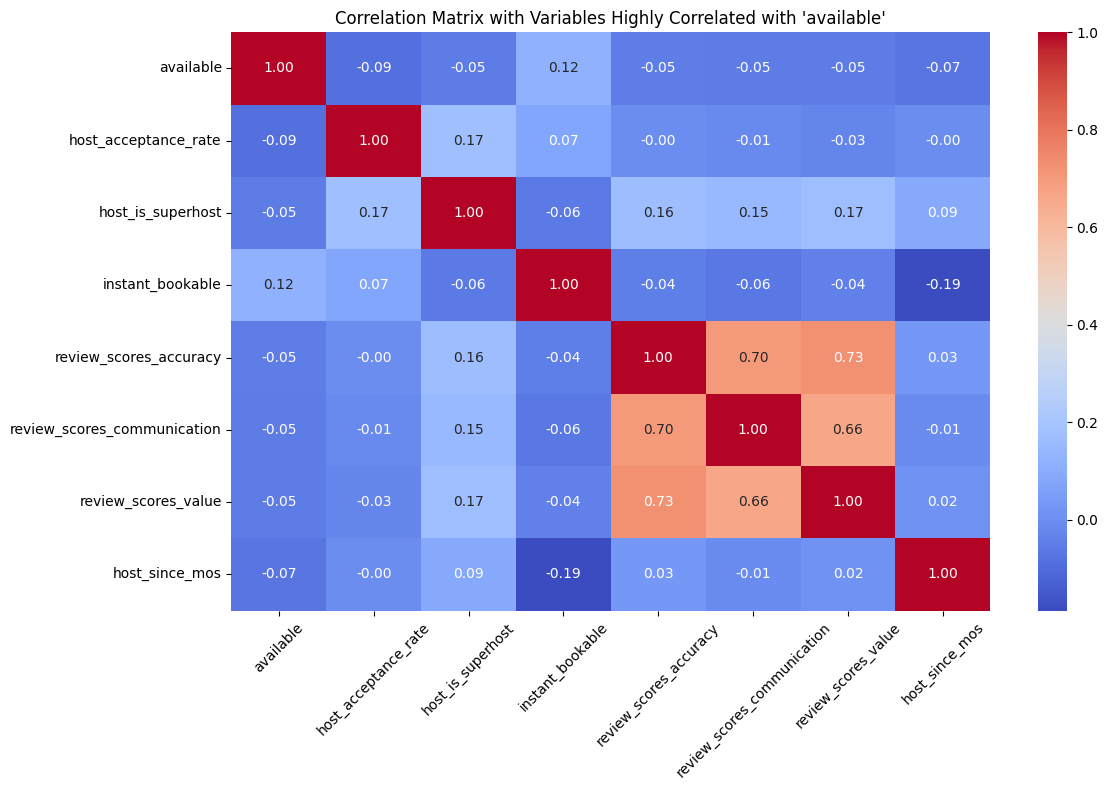

Variables with high correlation to 'available': ['available', 'host_acceptance_rate', 'host_is_superhost', 'instant_bookable', 'review_scores_accuracy', 'review_scores_communication', 'review_scores_value', 'host_since_mos']


In [315]:
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 'minimum_nights_listing', 
                 'maximum_nights_listing','price_smoothed']

excluded_vars = excluded_vars + potential_ivs

# Initialize a list to store variables with high correlation
control_vars_1st = []

# Define the correlation threshold
corr_threshold = 0.05

# Calculate correlations for each numeric variable in the DataFrame
for var in data.columns:
    if var in excluded_vars or not pd.api.types.is_numeric_dtype(data[var]):
        continue
    corr_with_available = data['available'].corr(data[var])
    if abs(corr_with_available) >= corr_threshold:
        control_vars_1st.append(var)

# Calculate and plot the final correlation matrix for the selected high correlation variables
final_corr_matrix = data[control_vars_1st].corr()

# Plot the final heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix with Variables Highly Correlated with 'available'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display the list of variables with high correlation
print("Variables with high correlation to 'available':", control_vars_1st)



In [327]:
control_vars_1st = ['host_since_mos', 'host_acceptance_rate', 'host_is_superhost', 'instant_bookable', 'host_listings_count',
                    'review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                    'review_scores_location','review_scores_value','reviews_per_month']

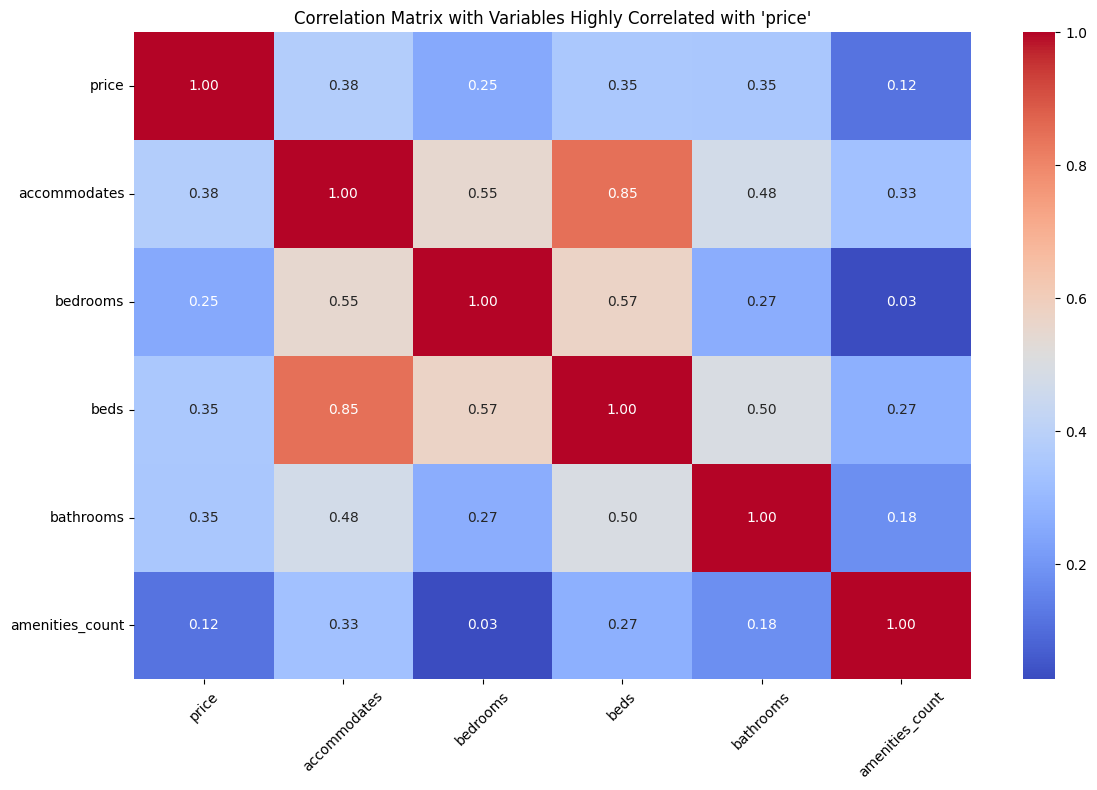

Variables with high correlation to 'price': ['price', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count']


In [317]:
# Initialize a list to store variables with high correlation
control_vars_2nd = []

# Define the correlation threshold
corr_threshold = 0.10

# Calculate correlations for each numeric variable in the DataFrame
for var in data.columns:
    if var in excluded_vars or not pd.api.types.is_numeric_dtype(data[var]):
        continue
    corr_with_available = data['price'].corr(data[var])
    if abs(corr_with_available) >= corr_threshold:
        control_vars_2nd.append(var)

# Calculate and plot the final correlation matrix for the selected high correlation variables
final_corr_matrix = data[control_vars_2nd].corr()

# Plot the final heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix with Variables Highly Correlated with 'price'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Display the list of variables with high correlation
print("Variables with high correlation to 'price':", control_vars_2nd)

In [329]:
control_vars_2nd = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'weekend']

In [330]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import gaussian_kde

# Assuming 'data' is your DataFrame and the necessary variables are defined (potential_ivs, control_vars_1st, control_vars_2nd)

# Define the cutoff date for early access to the smart pricing tool
cutoff_date = pd.to_datetime('2023-03-25')

# Convert 'date' to a numerical format (e.g., days since the start)
data['date_numeric'] = (data['date'] - data['date'].min()).dt.days

# Estimate the density at the cutoff
kde = gaussian_kde(data['date_numeric'])
density_at_cutoff = kde(cutoff_date.toordinal() - data['date'].min().toordinal())

# Calculate bandwidth using a rule (e.g., Silverman's rule)
bandwidth = 1.06 * min(np.std(data['date_numeric']), np.quantile(data['date_numeric'], 0.75) - np.quantile(data['date_numeric'], 0.25)) * len(data['date_numeric']) ** (-1/5)

# Create a binary variable for treatment assignment based on the cutoff date
data['post_cutoff'] = (data['date'] > cutoff_date).astype(int)
data['treatment_probability'] = data['available'] * data['post_cutoff']

# First stage: Estimate the propensity score
formula_1st_stage = 'treatment_probability ~ + C(week_indicator) + C(host_verifications) + C(host_response_time) + ' + ' + '.join(ivs) + ' + ' + ' + '.join(control_vars_1st)
model_1st_stage = smf.probit(formula_1st_stage, data=data).fit()
data['propensity_score'] = model_1st_stage.predict()

# Print the results
print(model_1st_stage.summary())

# Filter data within the bandwidth of the cutoff
bandwidth_filter = (data['date_numeric'] >= (cutoff_date.toordinal() - data['date'].min().toordinal() - bandwidth)) & (data['date_numeric'] <= (cutoff_date.toordinal() - data['date'].min().toordinal() + bandwidth))
data_bandwidth = data[bandwidth_filter]

# Include fixed effects for 'week_indicator'
formula_2nd_stage = 'price ~ propensity_score + C(week_indicator) + C(property_type) + C(room_type) + C(neighbourhood_cleansed) + ' + ' + '.join(control_vars_2nd)
model_2nd_stage = smf.ols(formula_2nd_stage, data=data_bandwidth).fit()

# Print the results
print(model_2nd_stage.summary())


         Current function value: 0.265187
         Iterations: 35


c:\Users\yirsu\.conda\envs\Bark\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                            Probit Regression Results                            
Dep. Variable:     treatment_probability   No. Observations:              2727480
Model:                            Probit   Df Residuals:                  2727388
Method:                              MLE   Df Model:                           91
Date:                   Mon, 18 Dec 2023   Pseudo R-squ.:                  0.5710
Time:                           06:43:29   Log-Likelihood:            -7.2329e+05
converged:                         False   LL-Null:                   -1.6861e+06
Covariance Type:               nonrobust   LLR p-value:                     0.000
                                                       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                           -9.6691    132.006     -0.073      0.942    -268.396     2